# Dimensionality Reduction

----------

## Internet Analytics - Lab 3

**Group**: J

**Names**:

* Maxime LANVIN
* Victor SALVIA
* Axel SJÖBERG

In [26]:
import json
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
from pyspark.mllib.linalg.distributed import CoordinateMatrix
import pandas as pd
from numpy import linalg as LA
import pickle
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
output_notebook()
from matplotlib.colors import rgb2hex 
from sklearn.linear_model import LinearRegression

%matplotlib inline
plt.style.use("ggplot")

Loading BokehJS ...

For some movies we have a vector of scores for each tag (within a closed set of tags). This results in a high-dimensional interpretation of each movie (**"tag space"**).

* **GOAL:** we want to represent this movies in a lower dimensional space using PCA.

Bellow one can see how the data looks like:

In [2]:
#!hdfs dfs -cat /ix/ml-20m/genome-tags.txt | tail -n 5

In [3]:
#!hdfs dfs -cat /ix/ml-20m/genome-scores.txt | tail -n 5

Now read the data and create a dictionary mapping each ID with its tag:

In [4]:
tags = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
tag_scores = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)

IDT = dict(tags.map(itemgetter("tagId", "tag")).collect())

---------------------------------
-------------

# EXERCISE 3.1

Construct an $M*N$ data matrix, where $M$ is the number of tags and $N$ the number of movies.
Do not include movies which do not have any tag.

* Plot the variance of each dimension (represented by tags) across all movies.
* Plot the eigenvalues of the $M*M$ covariance matrix.
* Explain the implications for dimensionality reduction.

For example, how many principal directions do you need to capture 2/3 of the variability in
the data?


----------------
-----------------------

## Matrix $M*N$ ($A$) 

How can we find the matrix $M*N$? In one file we do have a vector $M*N$ with all the scores for each movie. We should be able to transform that structure into the matrix.

In [5]:
# As found in the notebook "Intro_spark_EDA"
M = 1128 # tags
N = 10381 # movies with tags

In [6]:
matrix = tag_scores.map(itemgetter("tagId", "movieId", "relevance"))
matrix = np.asarray(matrix.collect())

In [7]:
#matrix[1:10] # This show the structure [[tagID,movieID,relevance], [...], ...]

While creating the matrix, we will keep `moviesID` which will be a vector mapping the index in the matrix of each movie with the real ID.

In [8]:
n = len(matrix)
X = np.zeros((1128,10381)) # 1128 tags, 10381 movies
m = -1
moviesID = np.zeros(10381)

for i in range(0,n):
    if i % 1128 == 0:
        m = m + 1
        moviesID[m] = matrix[i][1]
    
    X[int(matrix[i][0])-1][m] = matrix[i][2]

Now the matrix $X$ has the values we wanted to. **Keep in mind that X rows start at 0 and the real ID starts at 1.** This means that every time to select the row we will have to do `X[id-1,:]`.

## Variance of each dimension

$X = [x_1, ..., x_N]$, is our dataset. Each $x_i$ is a movie of dimension $M$, with all the scores for the different $M$ tags.

We want to know the covariance matrix of a given movie $x$. We know that: 
$$\mathrm{Var}(x) = \mathbb{E}[(x-\mathbb{E}[x])^2]$$
Then, we will center our matrix (all the data points, i.e. columns) and then estimate the covariance matrix:
1. $X = X - \overline{X}$
2. $\mathrm{Var}(x) \approx \frac{1}{N}X X^T = \frac{1}{N} \sum_{i = 1}^N x_i x_i^T$

In [9]:
X_center = X - X.mean(1).reshape([1128,1])
CX = (1/N)*np.matmul(X_center,np.transpose(X_center))
# CX.max() to get an idea of the magnitudes...

Now lets plot the diagonal so that we can see the variance of each dimension:

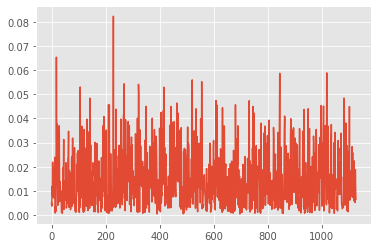

In [10]:
var = CX.diagonal()
plt.plot(var)

## Eigenvalues of the covariance matrix

Now we want to find the eigenvalues of the covariance matrix, order, and plot them.

The 10 first eigenvalues in order are: [2.75311225 1.22135338 0.99595557 0.66211171 0.58567336 0.47428225
 0.46138018 0.39717058 0.34148576 0.28886558]


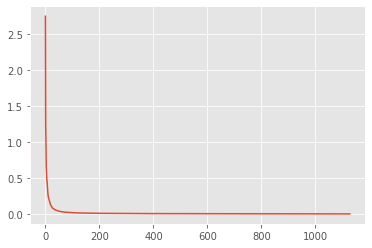

In [11]:
eva, eve = LA.eig(CX) # All the eigenvector have euclidean norm 1.
idx = eva.argsort()[::-1] # this inverts the order (from: < to: >).
eva = eva[idx]
eve = eve[:,idx]
plt.plot(eva)
print("The 10 first eigenvalues in order are:", eva[:10])

## Implications for dimensionality reduction

The implications are that the variance is mostly accumulated in the directions of the first (highest) eigenvalues, which will allow us to draw a low dimensional space in which most of the variance will still be present. Basically we have that:
$$X X^T = V D V^T$$
$$X X^T = \sum_{i = 1}^{M}\lambda_i v_i v_i^T$$
Where $V = [v_1,...,v_M]$ (ordered higher to smaller) are the eigenvectors and $D$ the eigenvalues ($\lambda_i$). Keeping only the highest eigenvalues with their eigenvectors will be able to reconstruct most of the covariance matrix. Furthermore, in that space the covariance matrix is $D$ and the eigenvalues are the directions capturing the variance. Since $D$ is diagonal there is no correlation between dimensions and all the variation is captured in the diagonal when we are in the $V$ space.

**NOTE:** All our eigenvalues are positive because the matrix is symetric (positive semidefinite).

Now let us see how many directions do we need in order to capture 2/3 of the total variance.

In [12]:
print("The tota variance is", sum(eva), "and the first 36 directions (1128 in total) account for", 100 * sum(eva[0:36])/sum(eva), "percent of the total variance.")

The tota variance is 17.100245817365966 and the first 36 directions (1128 in total) account for 66.65145090563263 percent of the total variance.


---------
------

# EXERCISE 3.2: Concept Space

For the five first principal directions, find the 10 tags that have the highest and lowest
coordinates in that direction.

* What concepts would you use to describe these dimensions?

Create a Python dict which maps every tag (name) to its coordinates in the 5 first principal
directions and save it to disk. This will be used later for the clustering exercise.

**NOTE:** We are going to find the 10 highest (absolute value) coordinates of each component. This means that within the direction they are the most meaningful tags.

-------
--------

## Principal Components

As we have seen before, the first eigenvectors are the directions that capture the most variance possible. Here we will explore the possible meaning of the first 5 dimensions.

In [13]:
# IMPORTANT TO REMEMBER: pc1 indexes go from 0 to 1127, but real tags are 1 to 1128.
pc1 = eve[:,0]
pc2 = eve[:,1]
pc3 = eve[:,2]
pc4 = eve[:,3]
pc5 = eve[:,4]

In [14]:
aux1 = pc1.argsort()[-5:][::-1]
tags1 = [IDT[key+1] for key in aux1]
print("Towards positive: ", tags1)

aux2 = pc1.argsort()[:5][::-1]
tags2 = [IDT[key+1] for key in aux2]
print("Towards negative: ", tags2)

Towards positive:  ['talky', 'social commentary', 'criterion', 'imdb top 250', 'great acting']
Towards negative:  ['silly fun', 'silly', 'bad plot', "so bad it's funny", 'predictable']


In this first dimension:
* **Positive direction**: Very good movies incorporating a lot of dialog and with some social criticism.
* **Negative direction**: Silly and bad movies which may be funny at points.

In [27]:
aux1 = pc2.argsort()[-5:][::-1]
tags1 = [IDT[key+1] for key in aux1]
print("Towards positive: ", tags1)

aux2 = pc2.argsort()[:5][::-1]
tags2 = [IDT[key+1] for key in aux2]
print("Towards negative: ", tags2)

Towards positive:  ['intimate', 'relationships', 'criterion', 'melancholic', 'loneliness']
Towards negative:  ['fast paced', 'chase', 'big budget', 'special effects', 'action']


In the second dimension:
* **Positive direction**: Emotional, relationships movie.
* **Negative direction**: Big budget, with action, special effects, and some chasing involved.

In [35]:
aux1 = pc3.argsort()[-5:][::-1]
tags1 = [IDT[key+1] for key in aux1]
print("Towards positive: ", tags1)

aux2 = pc3.argsort()[:5][::-1]
tags2 = [IDT[key+1] for key in aux2]
print("Towards negative: ", tags2)

Towards positive:  ['horror', 'weird', 'creepy', 'splatter', 'stylish']
Towards negative:  ['touching', 'heartwarming', 'love story', 'sentimental', 'feel-good']


In the third dimension:
* **Positive direction**: Horror, violent, and stylish movie.
* **Negative direction**: Touching, sentimental movie.

In [36]:
aux1 = pc4.argsort()[-5:][::-1]
tags1 = [IDT[key+1] for key in aux1]
print("Towards positive: ", tags1)

aux2 = pc4.argsort()[:5][::-1]
tags2 = [IDT[key+1] for key in aux2]
print("Towards negative: ", tags2)

Towards positive:  ['corruption', 'crime', 'murder', 'police investigation', 'thriller']
Towards negative:  ['scifi', 'sci-fi', 'imagination', 'visually stunning', 'visual']


In the third dimension:
* **Positive direction**: Typical thriller movie with crime, police, and corruption.
* **Negative direction**: Sci-fi movie with great visuals.

In [37]:
aux1 = pc5.argsort()[-5:][::-1]
tags1 = [IDT[key+1] for key in aux1]
print("Towards positive: ", tags1)

aux2 = pc5.argsort()[:5][::-1]
tags2 = [IDT[key+1] for key in aux2]
print("Towards negative: ", tags2)

Towards positive:  ['comedy', 'funny', 'hilarious', 'goofy', 'humorous']
Towards negative:  ['tense', 'suspenseful', 'secrets', 'conspiracy', 'thriller']


In the third dimension:
* **Positive direction**: Funny comedy.
* **Negative direction**: Thriller with secrets, conspiracies and a lot of suspense.

## Dictionary

The dictionary IDT ranges from key 1 to 1128. We will create a dictionary in which every tagID (**i**) will reference the correspondent coordinate of each principal component:
``dict[i] = [pc1[i], ..., pc5[i]]``

In [16]:
d = {}
for i in range(1,1129):
    l = [pc1[i-1],pc2[i-1],pc3[i-1],pc4[i-1],pc5[i-1]] # The index in pc1 is 0 to 1127 (real tag 1 to 1128)
    d.update({i : l})

In [17]:
#d[559] # as expected :)

Now to save it:

In [18]:
f = open("tag_to_5pc","wb")
pickle.dump(d,f)
f.close()

-------
-------


# EXERCISE 3.3: Movie Visualization

Project the movies of selected-movies.pickle on the first two principal directions.

* Create an interactive plot that displays the 2D-projection of the movies using bokeh and its hover tool. Color the nodes by their Rotten Tomatoes score.
* Based on your knowledge of these movies and information that you can get from the web, explain the coordinates of a few of the movies.
* How do the PCA directions correlate with the Rotten Tomatoes score?

Try projecting the movies on subsequent principal directions. Does it make sense based on
your knowledge of these movies? (Not needed for the hand-in).

----------
--------

In [21]:
with open("selected-movies.pickle", "rb") as f:
    movies = pickle.load(f, encoding="utf-8")

This is a set of 37 movies, each of them is (movieID, Title, RTScore).

## Project the movies on the first 2 components

How do we project the images in the first 2 principal components? Given that:
$$V^T x_e = x_v$$
Meaning the image in the canonical base ($x_e$) or in the eigenvectors space ($x_v$). Since in the $V$ space the vectors are orthogonal (symetric matrix) it can be proven that the projection on the first 2 vectors of $V$ ($v_1,v_2$) will be just keeping the respective coordinates:
$$x_v = a_1 v_1 + ... + a_M$$
$$x_{\text{projected}} = a_1 v_1 + a_2 v_2$$

In [34]:
aux_id = 1
aux = np.where(moviesID == aux_id) # this tells you the position
score = A[1:,aux].reshape(M,1)

In [19]:
# movies[0] # The structure of movies is [[movieID, title, score],[...],...]

Now we want to have a list with ($a_1$, $a_2$, movie name, score) for each movie:

In [22]:
l = []
for i, e in enumerate(movies):
    # First of all the vector:
    aux_id = e[0]
    aux = np.where(moviesID == aux_id)
    x_e = X[:,aux].reshape(M,1) # This is the vector of movies
    
    # Projection of score to eigenvectors:
    x_v = np.dot(np.transpose(eve),x_e) # first 2 components coordinates are projection :)
    
    l.append([float(x_v[0]),float(x_v[1]),e[1],e[2]]) # (x_1,x_2,title,score)

In [30]:
# Continuous colors
cmap = plt.get_cmap('viridis')
def val2rgb(val):
    return rgb2hex(cmap(val)[:3])

data = l
source = ColumnDataSource(
    data={
        "x": [x[0] for x in data],
        "y": [x[1] for x in data],
        "title": [x[2] for x in data],
        "color": [val2rgb(x[3]) for x in data],
        "score": [x[3] for x in data]
    })

hover = HoverTool(
    tooltips=[
        ("Title", "@title"), ("Score", "@score")
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=960, plot_height=360, tools=tools, title="Mouse over the dots", x_axis_label = "PC1", y_axis_label = "PC2")
p.circle("x", "y", source=source, size=20, color="color", alpha=0.5)
show(p, notebook_handle=True)

## Explanation for the coordinates of the movies

I would like to see the movies and why are where they are:

* Schindler's List: It clearly incorporates interesting dialog and social criticism ($PC1 \approx 8$). Also, it involves chasing from the Nazis and this is why ($PC2 \approx -4.5$).
* Spyder-Man: Since it is a well-known movie $PC1$ is positive, altouhgh not as much because it is not a top one. Clearly an action movie which means $PC2$ negative, as expected.
* ...

## Correlations

Looking at the plot above it seems that the higher values of the first component and lower of the second imply better results. However, one can clearly see that $PC1$ is much more correlated than $PC2$. This stems from the descriptions made from them before. $PC1$ was basically explaining a good movie vs a bad movie with some specificities. This is why it explains so much the quality of the movie.

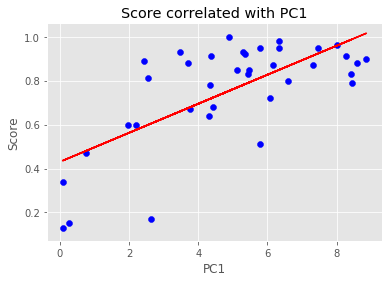

In [28]:
c1 = np.array([aux[0] for aux in l]).reshape(-1,1)
sc = np.array([aux[3] for aux in l]).reshape(-1,1)

linear_regressor = LinearRegression()
linear_regressor.fit(c1, sc)  # perform linear regression
sc_pred = linear_regressor.predict(c1)  # make predictions
plt.scatter(c1, sc, c='blue')
plt.title("Score correlated with PC1")
plt.xlabel("PC1")
plt.ylabel("Score")
plt.plot(c1, sc_pred, color='red')

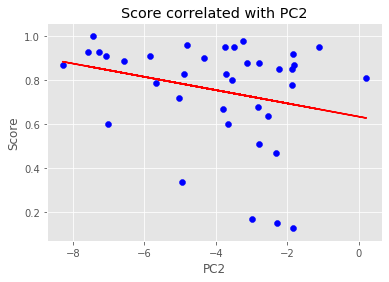

In [29]:
c2 = np.array([aux[1] for aux in l]).reshape(-1,1)
sc = np.array([aux[3] for aux in l]).reshape(-1,1)

linear_regressor = LinearRegression()
linear_regressor.fit(c2, sc)  # perform linear regression
sc_pred = linear_regressor.predict(c2)  # make predictions
plt.scatter(c2, sc, c='blue')
plt.title("Score correlated with PC2")
plt.ylabel("Score")
plt.xlabel("PC2")
plt.plot(c2, sc_pred, color='red')

## Projections on other interesting components

Let us see now the projection on the 4th and 5th components. 

In [34]:
l = []
for i, e in enumerate(movies):
    # First of all the vector:
    aux_id = e[0]
    aux = np.where(moviesID == aux_id)
    x_e = X[:,aux].reshape(M,1) # This is the vector of movies
    
    # Projection of score to eigenvectors:
    x_v = np.dot(np.transpose(eve),x_e) # first 2 components coordinates are projection :)
    
    l.append([float(x_v[3]),float(x_v[4]),e[1],e[2]]) # (x_1,x_2,title,score)

In [35]:
# Continuous colors
cmap = plt.get_cmap('viridis')
def val2rgb(val):
    return rgb2hex(cmap(val)[:3])

data = l
source = ColumnDataSource(
    data={
        "x": [x[0] for x in data],
        "y": [x[1] for x in data],
        "title": [x[2] for x in data],
        "color": [val2rgb(x[3]) for x in data],
        "score": [x[3] for x in data]
    })

hover = HoverTool(
    tooltips=[
        ("Title", "@title"), ("Score", "@score")
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=960, plot_height=360, tools=tools, title="Mouse over the dots", x_axis_label = "PC4", y_axis_label = "PC5")
p.circle("x", "y", source=source, size=20, color="color", alpha=0.5)
show(p, notebook_handle=True)

An interesting thing to point out here is that one can already see how $PC5$ explains way less than the previous components. It only encompasses 6 points (from -1 to 5), whereas the other components did 8, and most of the points are very similar if projected in this axis. Basically $PC5$ is starting to be less informative than previous components as expected.

* The Accused: this movie is a crime thriller, this is why $PC4$ is positive.
* The Fountain: science fiction movie, which is why $PC4$ very negative.
* American Pie: clearly a comedy, hence $PC5$ very high.